In [1]:
import sys
sys.path.append("../../..")  # Adjust the path as needed to import hira
import math
import pandas as pd
import torch

from hira.index.index import KMeansIndex
from hira.index.config import KMeansIndexConfig
from hira.tests.indexes_benchmark.line_profile_benchmark import generate_data
from hira.search.range_searcher import HalfspaceSearcher

/home/mohsen/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/mohsen/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Config
num_keys = [10_000, 20_000, 40_000, 60_000, 80_000]
iterations = 1
branching_factors = [4, 8, 16, 32, 64, 128]
distribution = "real"
dim = 128
target_results = 10
real_data_path = "../../tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz"

In [3]:
def run_benchmark(n, branching_factor):
    keys = generate_data(
        num_keys=n, dim=dim, distribution=distribution, real_data_path=real_data_path
    )

    num_levels = math.ceil(math.log(len(keys)) / math.log(branching_factor))

    # Build index (only once)
    config = KMeansIndexConfig(
        num_levels=num_levels,
        branching_factor=branching_factor,
        max_iterations=iterations,
        device="cpu",
    )
    index = KMeansIndex(config)
    index.build(keys)

    # Create query and find threshold (only once)
    query = torch.randn(dim)
    query_norm = query / torch.norm(query, p=2)
    all_scores = torch.matmul(keys, query_norm)
    sorted_scores, _ = torch.sort(all_scores, descending=True)
    threshold = sorted_scores[min(target_results, len(sorted_scores) - 1)].item()

    searcher = HalfspaceSearcher(enable_profiling=True)
    searcher.search(query, threshold, index)
    
    print(searcher.stats["all_keys"])
    print(searcher.stats["active_keys"])

    return searcher.stats["exact_checks"], n

In [4]:
results = {"n": [], "branching_factors": [], "exact_checks": [], "levels": []}

for n in num_keys:
    for bf in branching_factors:
        print(f"Running benchmark for n={n}, branching_factor={bf}...")
        checks, all_keys = run_benchmark(n, bf)
        results["n"].append(all_keys)
        results["branching_factors"].append(bf)
        results["exact_checks"].append(checks)
        results["levels"].append(math.ceil(math.log(all_keys) / math.log(bf)))

results = pd.DataFrame(results)

Running benchmark for n=10000, branching_factor=4...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 10000 real keys (dimension=128)
Building level 0...


WARNING clustering 10000 points to 2500 centroids: please provide at least 97500 training points
WARNING clustering 2500 points to 625 centroids: please provide at least 24375 training points
WARNING clustering 625 points to 156 centroids: please provide at least 6084 training points
WARNING clustering 156 points to 39 centroids: please provide at least 1521 training points
WARNING clustering 39 points to 9 centroids: please provide at least 351 training points
WARNING clustering 9 points to 2 centroids: please provide at least 78 training points
WARNING clustering 10000 points to 1250 centroids: please provide at least 48750 training points


[2, 9, 39, 148, 551, 1679]
[2, 9, 35, 126, 333, 641]
Running benchmark for n=10000, branching_factor=8...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 10000 real keys (dimension=128)
Building level 0...


WARNING clustering 1250 points to 156 centroids: please provide at least 6084 training points
WARNING clustering 156 points to 19 centroids: please provide at least 741 training points
WARNING clustering 19 points to 2 centroids: please provide at least 78 training points
WARNING clustering 10000 points to 625 centroids: please provide at least 24375 training points
WARNING clustering 625 points to 39 centroids: please provide at least 1521 training points
WARNING clustering 39 points to 2 centroids: please provide at least 78 training points


[2, 19, 147, 1141]
[2, 17, 133, 531]
Running benchmark for n=10000, branching_factor=16...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 10000 real keys (dimension=128)
Building level 0...
[2, 39, 582]
[2, 34, 360]
Running benchmark for n=10000, branching_factor=32...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 10000 real keys (dimension=128)
Building level 0...
[9, 312]
[9, 217]
Running benchmark for n=10000, branching_factor=64...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 10000 real keys (dimension=128)
Building level 0...
[2, 156]
[2, 126]
Running benchmark for n=10000, branching_factor=128...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_dat

WARNING clustering 10000 points to 312 centroids: please provide at least 12168 training points
WARNING clustering 312 points to 9 centroids: please provide at least 351 training points


  Loaded 10000 real keys (dimension=128)
Building level 0...
[78]
[68]
Running benchmark for n=20000, branching_factor=4...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 20000 real keys (dimension=128)
Building level 0...


WARNING clustering 20000 points to 5000 centroids: please provide at least 195000 training points
WARNING clustering 5000 points to 1250 centroids: please provide at least 48750 training points
WARNING clustering 1250 points to 312 centroids: please provide at least 12168 training points
WARNING clustering 312 points to 78 centroids: please provide at least 3042 training points
WARNING clustering 78 points to 19 centroids: please provide at least 741 training points
WARNING clustering 19 points to 4 centroids: please provide at least 156 training points
WARNING clustering 4 points to 1 centroids: please provide at least 39 training points
WARNING clustering 20000 points to 2500 centroids: please provide at least 97500 training points


[1, 4, 19, 77, 288, 1056, 2972]
[1, 4, 18, 68, 226, 583, 1060]
Running benchmark for n=20000, branching_factor=8...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 20000 real keys (dimension=128)
Building level 0...


WARNING clustering 2500 points to 312 centroids: please provide at least 12168 training points
WARNING clustering 312 points to 39 centroids: please provide at least 1521 training points
WARNING clustering 39 points to 4 centroids: please provide at least 156 training points
WARNING clustering 20000 points to 1250 centroids: please provide at least 48750 training points


[4, 39, 299, 2200]
[4, 37, 257, 893]
Running benchmark for n=20000, branching_factor=16...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 20000 real keys (dimension=128)
Building level 0...


WARNING clustering 1250 points to 78 centroids: please provide at least 3042 training points
WARNING clustering 78 points to 4 centroids: please provide at least 156 training points
WARNING clustering 20000 points to 625 centroids: please provide at least 24375 training points


[4, 78, 1178]
[4, 68, 619]
Running benchmark for n=20000, branching_factor=32...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 20000 real keys (dimension=128)
Building level 0...
[19, 625]
[19, 389]
Running benchmark for n=20000, branching_factor=64...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz


WARNING clustering 625 points to 19 centroids: please provide at least 741 training points


  Loaded 20000 real keys (dimension=128)
Building level 0...
[4, 312]
[4, 239]
Running benchmark for n=20000, branching_factor=128...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 20000 real keys (dimension=128)
Building level 0...
[1, 156]
[1, 132]
Running benchmark for n=40000, branching_factor=4...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 40000 real keys (dimension=128)
Building level 0...


WARNING clustering 40000 points to 10000 centroids: please provide at least 390000 training points
WARNING clustering 10000 points to 2500 centroids: please provide at least 97500 training points
WARNING clustering 2500 points to 625 centroids: please provide at least 24375 training points
WARNING clustering 625 points to 156 centroids: please provide at least 6084 training points
WARNING clustering 156 points to 39 centroids: please provide at least 1521 training points
WARNING clustering 39 points to 9 centroids: please provide at least 351 training points
WARNING clustering 9 points to 2 centroids: please provide at least 78 training points
WARNING clustering 40000 points to 5000 centroids: please provide at least 195000 training points


[2, 9, 39, 148, 573, 1994, 5090]
[2, 9, 36, 135, 412, 1053, 1744]
Running benchmark for n=40000, branching_factor=8...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 40000 real keys (dimension=128)
Building level 0...


WARNING clustering 5000 points to 625 centroids: please provide at least 24375 training points
WARNING clustering 625 points to 78 centroids: please provide at least 3042 training points
WARNING clustering 78 points to 9 centroids: please provide at least 351 training points
WARNING clustering 9 points to 1 centroids: please provide at least 39 training points
WARNING clustering 40000 points to 2500 centroids: please provide at least 97500 training points


[1, 9, 78, 583, 3877]
[1, 9, 67, 419, 1513]
Running benchmark for n=40000, branching_factor=16...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 40000 real keys (dimension=128)
Building level 0...


WARNING clustering 2500 points to 156 centroids: please provide at least 6084 training points
WARNING clustering 156 points to 9 centroids: please provide at least 351 training points
WARNING clustering 40000 points to 1250 centroids: please provide at least 48750 training points


[9, 156, 2276]
[9, 128, 1069]
Running benchmark for n=40000, branching_factor=32...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 40000 real keys (dimension=128)
Building level 0...


WARNING clustering 1250 points to 39 centroids: please provide at least 1521 training points


[1, 39, 1198]
[1, 36, 679]
Running benchmark for n=40000, branching_factor=64...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 40000 real keys (dimension=128)
Building level 0...
[9, 625]
[9, 420]
Running benchmark for n=40000, branching_factor=128...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 40000 real keys (dimension=128)
Building level 0...
[2, 312]
[2, 239]
Running benchmark for n=60000, branching_factor=4...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 60000 real keys (dimension=128)
Building level 0...


WARNING clustering 60000 points to 15000 centroids: please provide at least 585000 training points
WARNING clustering 15000 points to 3750 centroids: please provide at least 146250 training points
WARNING clustering 3750 points to 937 centroids: please provide at least 36543 training points
WARNING clustering 937 points to 234 centroids: please provide at least 9126 training points
WARNING clustering 234 points to 58 centroids: please provide at least 2262 training points
WARNING clustering 58 points to 14 centroids: please provide at least 546 training points
WARNING clustering 14 points to 3 centroids: please provide at least 117 training points
WARNING clustering 60000 points to 7500 centroids: please provide at least 292500 training points


[3, 14, 57, 218, 864, 2825, 7046]
[3, 13, 51, 201, 597, 1473, 2250]
Running benchmark for n=60000, branching_factor=8...
  Loading real data from: /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Meta-Llama-3-8B-Instruct_layer31_20251219_005742.npz
  Loaded 60000 real keys (dimension=128)
Building level 0...


KeyboardInterrupt: 

In [5]:
# results.to_csv("ball_pruning_power_results.csv", index=False)
results = pd.read_csv("ball_pruning_power_results.csv")

In [12]:
import matplotlib.pyplot as plt

# Calculate pruning power (exact_checks / n)
results['pruning_power'] = results['exact_checks'] / results['n']

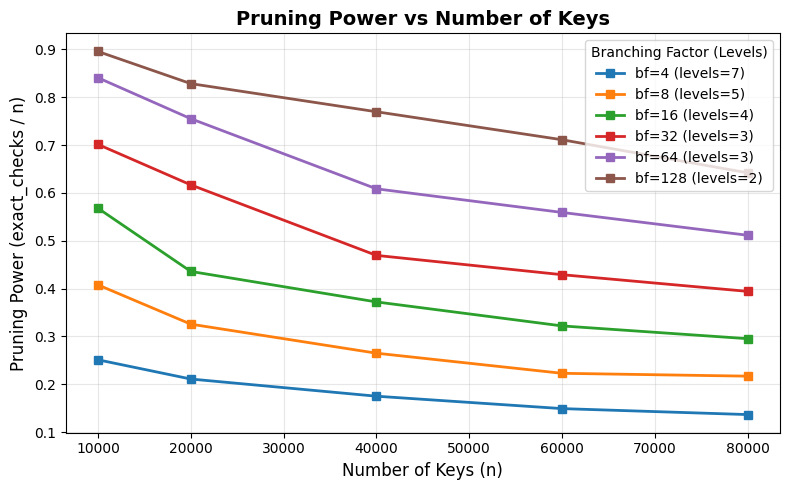

In [ ]:
# Plot 2: Pruning power vs n (for each branching factor)
plt.figure(figsize=(8, 5))

for bf in results["branching_factors"].unique():
    subset = results[results["branching_factors"] == bf]

    label = f'bf={bf} (levels={subset["levels"].tolist()[0]})'
    plt.plot(subset["n"], subset["pruning_power"], marker="s", label=label, linewidth=2)

plt.xlabel("Number of Keys (n)", fontsize=12)
plt.ylabel("Pruning Power (exact_checks / n)", fontsize=12)
plt.title("Pruning Power vs Number of Keys", fontsize=14, fontweight="bold")
plt.legend(title="Branching Factor (Levels)")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# plt.savefig("pruning_power.png", dpi=300)

plt.show()